In [7]:
#!pip install -r requirements.txt



import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv
import vtk
from vtk.util import numpy_support
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# take folder of a single lung and preprocess and segments the lungs


# local computer
#INPUT_FOLDER = './dataset/manifest-1674660649243'

#lab 
INPUT_FOLDER = '../dataset/manifest-1674660649243'

NLST = f'{INPUT_FOLDER}/NLST flatten'

expFolder = f'{NLST}/100004/01-02-2001-NA-NLST-LSS-01308/1.000000-2OPATOAQUL4C410.22-06725'
cases_root_folder = f'{NLST}/100004/01-02-2001-NA-NLST-LSS-01308/'
meta_data = './dataset/metadata/participant_d040722.csv'
# an array including path of all the scan folders
cases_path = [cases_root_folder + fileName for fileName in os.listdir(cases_root_folder)]

class preprocess:
    def __init__(self, input_folder, metadata_path = None, dilation_kernel_size = 2, dilation_iteration = 2):
        
        self.metadata_path = metadata_path
        self.dilation_kernel_size = dilation_kernel_size
        self.dilation_iteration = dilation_iteration
        self.input_folder = input_folder
        self.loaded_scans = self.load_scan(self.input_folder)
        self.pid = self.loaded_scans[1].PatientID
        self.scan_HU_values = self.get_pixels_hu(self.loaded_scans)
        self.resampled_3d_image, self.spacing = self.resample(self.scan_HU_values, self.loaded_scans, [1,1,1])
        self.segmented_lung_mask = self.segment_lung_mask(self.resampled_3d_image, True, dilation = '3d', kernel_size = self.dilation_kernel_size, iteration = self.dilation_iteration)
        self.segmented_grayscale_scan = self.hu_transform(self.resampled_3d_image, self.segmented_lung_mask, lung_window= [-1200, 600])
        self.label = self.load_metadata()

    def load_metadata(self):
        #path = path if path else self.metadata_path
        path =self.metadata_path
        metadata = pd.read_csv(path)
        metadata = metadata.query('rndgroup == 1 ')
        metadata = metadata[[ 'pid','lung_cancer', 'conflc', 'canc_rpt_link', 'cancyr' ]].query(f'pid == {self.pid}')['lung_cancer'].to_list()[0]


        
        return metadata


    def hu_transform(self, scan_HU_value, mask, lung_window = [-1200, 600]):
        
        mask = mask.astype(np.int16)
        
        scaled_scan = (scan_HU_value-lung_window[0])/(lung_window[1]-lung_window[0])
        scaled_scan[scaled_scan<0]=0
        scaled_scan[scaled_scan>1]=1

        trans_scaled_scan = (scaled_scan*255).astype('uint8')
        segmented_trans_scan = mask * trans_scaled_scan
        
        return segmented_trans_scan

    def visualize_intensity_histogram(self, array ):
        plt.hist(array.flatten(), bins=100, color='c')
        plt.xlabel("intensity range")
        plt.ylabel("Frequency")
        plt.show()

                

    def load_scan(self, path):
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        try:
            slice_thickness = np.abs(
                slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(
                slices[0].SliceLocation - slices[1].SliceLocation)

        for s in slices:
            s.SliceThickness = slice_thickness

        return slices


    def get_pixels_hu(self, slices):
        image = np.stack([s.pixel_array for s in slices])
        # Convert to int16 (from sometimes int16),
        # should be possible as values should always be low enough (<32k)
        image = image.astype(np.int16)

        # Set outside-of-scan pixels to 0
        # The intercept is usually -1024, so air is approximately 0
        image[image == -2000] = 0

        # Convert to Hounsfield units (HU)
        for slice_number in range(len(slices)):

            intercept = slices[slice_number].RescaleIntercept
            slope = slices[slice_number].RescaleSlope

            if slope != 1:
                image[slice_number] = slope * image[slice_number].astype(np.float64)
                image[slice_number] = image[slice_number].astype(np.int16)

            image[slice_number] += np.int16(intercept)

        return np.array(image, dtype=np.int16)

    def resample(self, image, scan, new_spacing=[1, 1, 1]):
        # Determine current pixel spacing
        spacing = np.array([scan[0].SliceThickness] +
                           list(scan[0].PixelSpacing), dtype=np.float32)

        resize_factor = spacing / new_spacing
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / image.shape
        new_spacing = spacing / real_resize_factor

        image = ndimage.zoom(image, real_resize_factor, mode='nearest')

        return image, new_spacing


    def largest_label_volume(self, im, bg=-1):
        vals, counts = np.unique(im, return_counts=True)

        counts = counts[vals != bg]
        vals = vals[vals != bg]

        if len(counts) > 0:
            return vals[np.argmax(counts)]
        else:
            return None



    def dilate(self, img, kernel_size, iteration, three_d=False, shape = 'circular'):

        img = img.copy()
        if three_d:
            if shape == 'circular' :
                kernel = morphology.ball(kernel_size).astype(np.uint8)
            elif shape == 'square' :
                kernel = np.ones((kernel_size, kernel_size, kernel_size), np.uint8)
            img = ndimage.binary_dilation(img, kernel, iterations=iteration)
        else:
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            for i, slide in enumerate(img):
                img[i] = ndimage.binary_dilation(
                    slide, kernel, iterations=iteration)

        return img


    def segment_lung_mask(self, image, fill_lung_structures=True, dilation='3d', kernel_size=3, iteration=5):

        # 1 in dilate does 2d dilation and 2 does 3d
        # not actually binary, but 1 and 2.
        # 0 is treated as background, which we do not want
        binary_image = np.array(image > -320, dtype=np.int8)+1
        # plot_3d(binary_image - 1, 0, 'thresholding')
        labels = measure.label(binary_image)

        # Pick the pixel in the very corner to determine which label is air.
        #   Improvement: Pick multiple background labels from around the patient
        #   More resistant to "trays" on which the patient lays cutting the air
        #   around the person in half
        background_labels = labels[0:2, 0:2, 0:2]
        background_label = np.median(background_labels)

        # Fill the air around the person
        binary_image[background_label == labels] = 2

        # Method of filling the lung structures (that is superior to something like
        # morphological closing)
        if fill_lung_structures:
            # For every slice we determine the largest solid structure
            for i, axial_slice in enumerate(binary_image):
                axial_slice = axial_slice - 1
                labeling = measure.label(axial_slice)
                l_max = self.largest_label_volume(labeling, bg=0)

                if l_max is not None:  # This slice contains some lung
                    binary_image[i][labeling != l_max] = 1

        binary_image -= 1  # Make the image actual binary
        binary_image = 1-binary_image  # Invert it, lungs are now 1

        # Remove other air pockets insided body
        labels = measure.label(binary_image, background=0)
        l_max = self.largest_label_volume(labels, bg=0)
        if l_max is not None:  # There are air pockets
            binary_image[labels != l_max] = 0

        if dilation == '2d':
            binary_image = self.dilate(binary_image, kernel_size, iteration)
        elif dilation == '3d':
            binary_image = self.dilate(binary_image, kernel_size, iteration, True)

        return binary_image


#scan = preprocess(cases_path[0])
#print(scan.segmented_lung_mask)
# print(scan.segmented_lung_mask)




def prepare_scans(cases_path, metadata_path):
    scans = []
    for case in cases_path: 
        scan = preprocess(case, metadata_path)
        scans.append(scan)
    return scans


scans = prepare_scans(cases_path, meta_data)

print(cases_path)
#scan = preprocess(cases_path[0], meta_data)
#scan.visualize_intensity_histogram(scan.segmented_grayscale_scan)

#print(scan.hu_trans_segmented)
#print(f'{type(scan.resampled_3d_image)} {scan.resampled_3d_image.dtype} {scan.resampled_3d_image.dtype.type} shape of hu values : {scan.resampled_3d_image.shape}')
#print(f'{type(scan.segmented_lung_mask)} {scan.segmented_lung_mask.dtype} {scan.segmented_lung_mask.dtype.type} shape of mask : {scan.segmented_lung_mask.shape} {scan.segmented_lung_mask.astype(np.int16).dtype}')



#print(scan.resampled_3d_image.astype(np.int16))
#scan_vis = vtk_visualization(scan.segmented_grayscale_scan)
#scan_vis.visualize(scan_vis.ren)

C:\Users\Woody\AppData\Local\Temp\ipykernel_1868\3875402.py:52: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path)
C:\Users\Woody\AppData\Local\Temp\ipykernel_1868\3875402.py:52: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path)
C:\Users\Woody\AppData\Local\Temp\ipykernel_1868\3875402.py:52: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path)
C:\Users\Woody\AppData\Local\Temp\ipykernel_1868\3875402.py:52: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path)
C:\Users\Woody\AppData\Local\Temp\ipykernel_1868\3875402.py:52: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  meta

['../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/1.000000-2OPATOAQUL4C410.22-06725', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/1.000000-2OPATOAQUL4C410.22-68378', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/2.000000-0OPAGELS16B3402.512060.00.11.375-72968', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/2.000000-1OPAGELSQXD3102.514048.00.01.5-58322', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/2.000000-1OPASEVZOOMB30f2802.012070.040.0null-30925', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/2.000000-2OPAGELS16D3802.5120818.0nullnull-04022', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/3.000000-0OPAGELS16D3202.512060.00.11.375-93418', '../dataset/manifest-1674660649243/NLST flatten/100004/01-02-2001-NA-NLST-LSS-01308/3.

In [8]:
class vtk_visualization:

    colors = vtk.vtkNamedColors()

    def __init__(self, structure):
        self.structure = structure 
        self.imData = self.numpyToImageDate(structure)
        self.volumeMapper, self.volumeProperty = self.imDataToVolumeMapper(self.imData)
        self.vtkVolume = vtk.vtkVolume()
        self.volume = self.vMapperToVolume(self.vtkVolume, self.volumeMapper, self.volumeProperty)
        self.ren = self.renderVol(self.volume)

    def numpyToImageDate(self, numpyScan):
        scan = numpyScan.transpose(2,0,1)
        imData = vtk.vtkImageData()
        vtk_data = numpy_support.numpy_to_vtk(scan.ravel(order= 'F'), deep=True, array_type=vtk.VTK_DOUBLE)

        imData.SetDimensions(scan.shape)
        imData.SetSpacing([.1,.1,.1])
        imData.SetOrigin([0,0,0])
        imData.GetPointData().SetScalars(vtk_data)

        return imData


    def imDataToVolumeMapper(self, imData ):
        
    
        opacity = vtk.vtkPiecewiseFunction()
        opacity.AddPoint(0, 0)
        opacity.AddPoint(150, .05)
        opacity.AddPoint(180, 1)
        opacity.AddPoint(210, .1)
        opacity.AddPoint(255, .001)
    

        color = vtk.vtkColorTransferFunction()
        r, g, b = vtk_visualization.colors.GetColor3ub('black')
        color.AddRGBPoint(0, r, g, b)

        r, g, b = vtk_visualization.colors.GetColor3ub('white')
        color.AddRGBPoint(255, r, g, b)
        '''
        r, g, b = vtk_visualization.colors.GetColor3ub('white')
        color.AddRGBPoint(180, r, g, b)
        
        r, g, b = vtk_visualization.colors.GetColor3ub('red')
        color.AddRGBPoint(254, r, g, b)
        '''
        '''        
        r, g, b = vtk_visualization.colors.GetColor3ub('blue')
        color.AddRGBPoint(255, r, g, b)
        '''
        volumeProperty = vtk.vtkVolumeProperty()
        volumeProperty.SetColor(color)
        volumeProperty.SetScalarOpacity(opacity)
        volumeProperty.SetInterpolationTypeToLinear()
        volumeProperty.SetIndependentComponents(2)


        volumeMapper = vtk.vtkOpenGLGPUVolumeRayCastMapper()
        volumeMapper.SetInputData(imData)
        #volumeMapper.SetBlendModeToAverageIntensity()
        return volumeMapper, volumeProperty 


    def vMapperToVolume(self, volume, mapper, property):
        volume.SetMapper(mapper)
        volume.SetProperty(property)
        return volume


    def renderVol(self, volume):

        ren = vtk.vtkRenderer()
        ren.AddVolume(volume)
        ren.SetBackground(vtk_visualization.colors.GetColor3ub('black'))
        return ren

    def visualize(self, ren):

        render_window = vtk.vtkRenderWindow()
        render_window.AddRenderer(ren)
        render_window.SetSize(400, 400)


        render_window_interactor = vtk.vtkRenderWindowInteractor()
        render_window_interactor.SetRenderWindow(render_window)
        render_window_interactor.Initialize()

        ren.ResetCamera()
        ren.GetActiveCamera().Zoom(1.5)

        render_window.Render()
        render_window_interactor.Start()


scan_vis = vtk_visualization(scans[0].segmented_grayscale_scan)
scan_vis.visualize(scan_vis.ren)

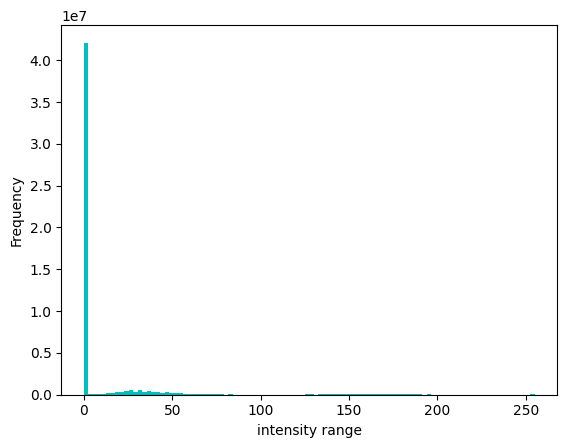

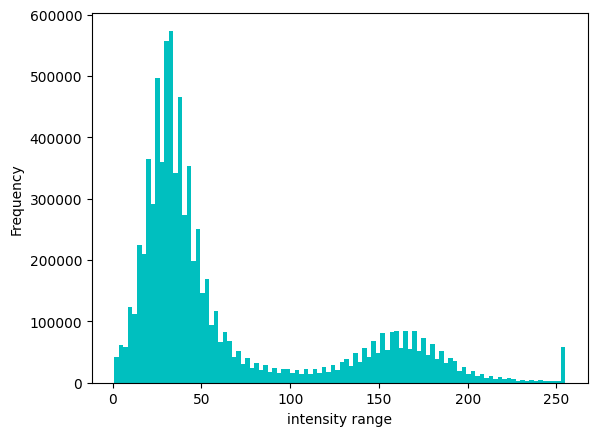

In [9]:
intensities = scans[0].segmented_grayscale_scan.flatten()
scans[0].visualize_intensity_histogram(scans[0].segmented_grayscale_scan)


arr = np.delete(intensities, np.where(intensities == 0))
#arr = np.delete(arr, np.where(arr == 255))
scans[0].visualize_intensity_histogram(arr)



In [10]:
from skimage.filters import threshold_multiotsu

thresholds = threshold_multiotsu(arr,2)

print(thresholds)

[99]


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



def return_xy(scans):
    x = []
    y = []
    for scan in scans: 
        x.append(scan.segmented_grayscale_scan)
        y.append(scan.label)
    return x, y

xs, ys = return_xy(scans)

print((xs[8].shape))
# all the images should be resized to a certain dimention before inputting in the model
#train_loader = tf.data.Dataset.from_tensor_slices((xs, ys))


(320, 313, 313)


In [12]:
metadata = scan.load_metadata()
print(f'label is :{metadata}')
print(type(metadata))

NameError: name 'scan' is not defined